In [1]:
import torch
import torch.nn as nn
import albumentations
from PIL import Image, ImageFile
import numpy as np

# Below line tells Pillow to attempt to load image files
# even if they are incomplete or truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True 

import os, glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import random

from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATA_DIR = '/kaggle/input/captcha-version-2-images/samples'
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 2
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class ClassificationDataset:
    def __init__(self, image_paths, targets, resize=None):
        # resize = (height, width)
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
            ]
        )
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert('RGB')
        targets = self.targets[item]
        
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [4]:
image_files = glob.glob(os.path.join(DATA_DIR, '*.png')) + glob.glob(os.path.join(DATA_DIR, '*.jpg'))
len(image_files)

1070

In [5]:
for c in image_files[0].split('/')[-1][:-4]: 
    print(c)

6
n
6
g
g


In [6]:
targets_orig = [x.split('/')[-1][:-4] for x in image_files]
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

In [7]:
targets[0]

['6', 'n', '6', 'g', 'g']

In [8]:
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()
lbl_enc.fit(targets_flat)

LabelEncoder()

In [9]:
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc)
targets_enc = targets_enc + 1

In [10]:
lbl_enc.inverse_transform(targets_enc[0])

array(['7', 'p', '7', 'm', 'm'], dtype='<U1')

In [11]:
train_imgs, test_imgs, train_targets, test_targets, _, test_targets_orig = train_test_split(image_files, targets_enc, targets_orig, test_size=0.1)

In [12]:
len(train_imgs), len(test_imgs)

(963, 107)

In [13]:
train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))
test_dataset = ClassificationDataset(image_paths=test_imgs, targets=test_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

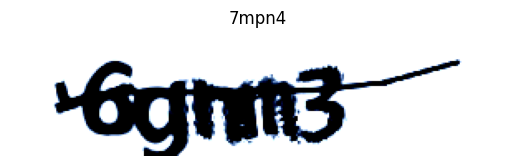

In [14]:
plt.imshow(np.array(train_dataset[0]['images'].permute(1, 2, 0)))
plt.title(''.join(lbl_enc.inverse_transform(train_dataset[0]['targets'])))
plt.axis('off')
plt.show();

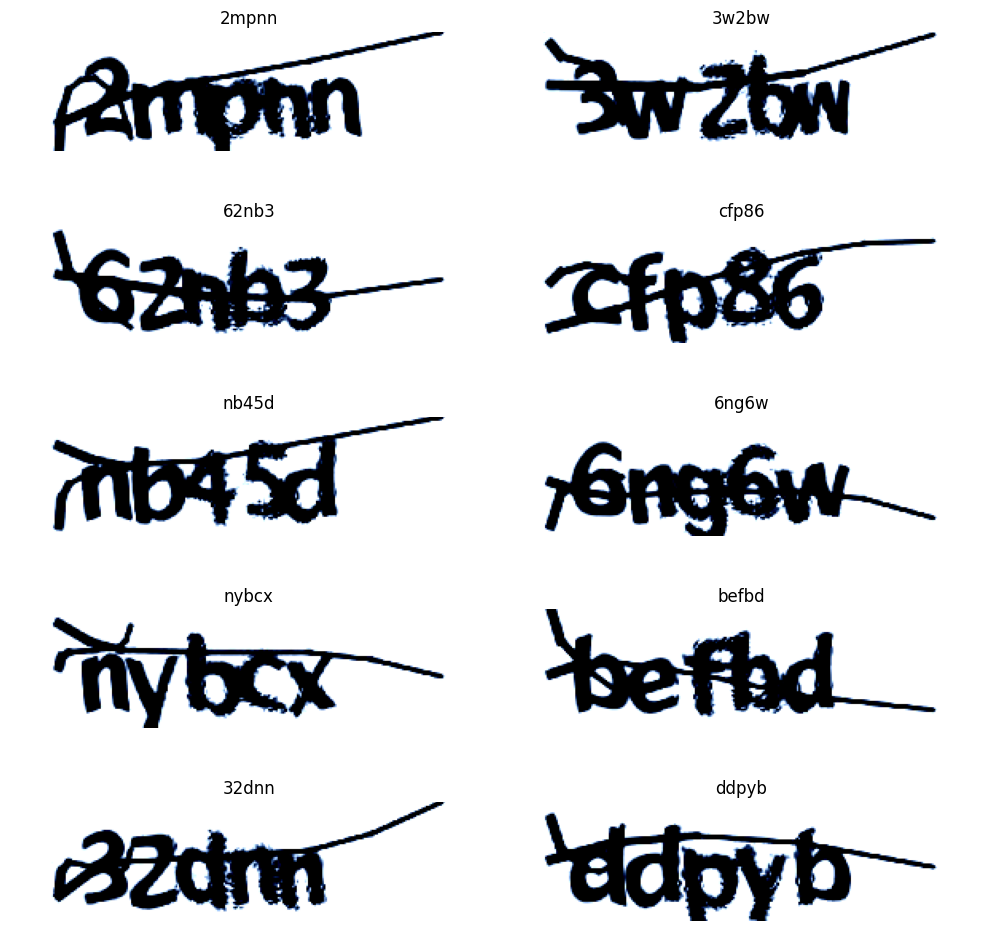

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    random_idx = random.randint(0, len(train_dataset)-1)
    img = train_dataset[random_idx]['images'].permute(1, 2, 0)
    label = lbl_enc.inverse_transform(train_dataset[random_idx]['targets']-1)
    
    ax.imshow(img)
    ax.set_title(''.join(label))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [17]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3, 6), padding=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.linear = nn.Linear(1152, 64)
        self.drop = nn.Dropout(0.2)
        self.lstm = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
    def forward(self, images, targets=None):
        bs, _, _, _ = images.size()
#         print(f"Input image size - {images.size()}")
        x = F.relu(self.conv1(images))
#         print(f"Size after relu and conv1 - {x.size()}")
        x = self.pool1(x)
#         print(f"Size after max pool 1 - {x.size()}")
        x = F.relu(self.conv2(x))
#         print(f"Size after relu and conv2 - {x.size()}")
        x = self.pool2(x)
#         print(f"Size after max pool 2 - {x.size()}")
        x = x.permute(0, 3, 1, 2)
#         print(f"Size after permutation - {x.size()}")
        x = x.view(bs, x.size(1), -1)
#         print(f"Size after view change - {x.size()}")
        x = F.relu(self.linear(x))
#         print(f"Size after relu and linear - {x.size()}")
        x = self.drop(x)
#         print(f"Size after dropout - {x.size()}")
        x, _ = self.lstm(x)
#         print(f"Size after lstm - {x.size()}")
        x = self.output(x)
#         print(f"Size after output layer - {x.size()}")
        x = x.permute(1, 0, 2)
#         print(f"Size after last permutation - {x.size()}")
        
        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32)
            target_lengths = torch.full(size=(bs,), fill_value=targets.size(1), dtype=torch.int32)
            loss = nn.CTCLoss(blank=0)(log_probs, targets, input_lengths, target_lengths)
            return x, loss
        return x, None

In [18]:
model = CaptchaModel(19)
model.to(DEVICE)
rand_img = torch.rand((1, 3, 75, 300))
x, _ = model(rand_img.to(DEVICE), torch.rand((1, 5)))

In [19]:
x

tensor([[[-0.1559, -0.1263,  0.0796,  ...,  0.1253, -0.0784, -0.1236]],

        [[-0.1639, -0.1495,  0.0885,  ...,  0.1113, -0.0542, -0.1259]],

        [[-0.1781, -0.1357,  0.1240,  ...,  0.1150, -0.0678, -0.1646]],

        ...,

        [[-0.1717, -0.1378,  0.0854,  ...,  0.1090, -0.0432, -0.1695]],

        [[-0.1164, -0.1586,  0.0768,  ...,  0.0845, -0.0390, -0.1629]],

        [[-0.0774, -0.1604,  0.0875,  ...,  0.0545, -0.0433, -0.1506]]],
       device='cuda:0', grad_fn=<PermuteBackward0>)

In [20]:
def train_fn(model, dataloader, optimizer):
    model.train()
    fin_loss = 0.0 
    tk0 = tqdm(dataloader, total=len(dataloader))
    
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(DEVICE)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()
    return fin_loss / len(dataloader)

def eval_fn(model, dataloader):
    model.eval()
    fin_loss = 0.0 
    fin_preds = []
    tk0 = tqdm(dataloader, total=len(dataloader))
    
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(DEVICE)
        batch_preds, loss = model(**data)
        fin_loss += loss.item()
        fin_preds.append(batch_preds)
    return fin_preds, fin_loss / len(dataloader)

In [21]:
def remove_duplicates(x):
    if len(x) < 2: return x
    
    fin = ''
    
    for j in x:
        if fin == '':
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin

def decode_preds(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append('§')
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(p)
        tp = ''.join(temp).replace('§', '')
        cap_preds.append(remove_duplicates(tp))
    return cap_preds

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

In [23]:
total_train_loss, total_test_loss = [], []

for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_dataloader, optimizer)
    valid_preds, test_loss = eval_fn(model, test_dataloader)
    valid_captcha_preds = []
    
    for vp in valid_preds:
        current_preds = decode_preds(vp, lbl_enc)
        valid_captcha_preds.extend(current_preds)
    
    combined = list(zip(test_targets_orig, valid_captcha_preds))
    print(combined[:10])
    test_dup_rem = [remove_duplicates(c) for c in test_targets_orig]
    accuracy = accuracy_score(test_dup_rem, valid_captcha_preds)
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | Accuracy {accuracy}")
    scheduler.step(test_loss)

100%|██████████| 14/14 [00:00<00:00, 26.96it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 0: Train Loss 9.1915 | Test Loss 3.3212 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.40it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 1: Train Loss 3.2869 | Test Loss 3.2908 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.08it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 2: Train Loss 3.2686 | Test Loss 3.2837 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 25.49it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 3: Train Loss 3.2670 | Test Loss 3.2840 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.90it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 4: Train Loss 3.2665 | Test Loss 3.2801 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.99it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 5: Train Loss 3.2673 | Test Loss 3.2784 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 41.26it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 6: Train Loss 3.2666 | Test Loss 3.2777 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.03it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 7: Train Loss 3.2669 | Test Loss 3.2791 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.86it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 8: Train Loss 3.2669 | Test Loss 3.2792 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 43.10it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 9: Train Loss 3.2666 | Test Loss 3.2798 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.82it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 10: Train Loss 3.2662 | Test Loss 3.2797 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 31.45it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 11: Train Loss 3.2662 | Test Loss 3.2811 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 41.75it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 12: Train Loss 3.2655 | Test Loss 3.2779 | Accuracy 0.0
Epoch 00013: reducing learning rate of group 0 to 2.4000e-04.


100%|██████████| 14/14 [00:00<00:00, 23.45it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 13: Train Loss 3.2653 | Test Loss 3.2807 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 36.34it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 14: Train Loss 3.2648 | Test Loss 3.2817 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.97it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 15: Train Loss 3.2627 | Test Loss 3.2796 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.69it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 16: Train Loss 3.2608 | Test Loss 3.2840 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 35.92it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 17: Train Loss 3.2524 | Test Loss 3.2727 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 43.26it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 18: Train Loss 3.2352 | Test Loss 3.2593 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 43.53it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 19: Train Loss 3.1964 | Test Loss 3.2102 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.40it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 20: Train Loss 3.1256 | Test Loss 3.0743 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.80it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 21: Train Loss 3.0121 | Test Loss 2.9106 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 42.63it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 22: Train Loss 2.8592 | Test Loss 2.6863 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 24.03it/s]


[('d4ppy', ''), ('ppwyd', ''), ('x8e8n', ''), ('823p2', ''), ('6cm6m', ''), ('nbmx7', ''), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', ''), ('yemy4', '')]
Epoch 23: Train Loss 2.6433 | Test Loss 2.3995 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 41.45it/s]


[('d4ppy', ''), ('ppwyd', 'p'), ('x8e8n', ''), ('823p2', '2'), ('6cm6m', ''), ('nbmx7', '7'), ('w48cw', ''), ('wgnwp', ''), ('3n2b4', '2'), ('yemy4', '')]
Epoch 24: Train Loss 2.3375 | Test Loss 2.0148 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 43.28it/s]


[('d4ppy', '4py'), ('ppwyd', 'py'), ('x8e8n', ''), ('823p2', '2p2'), ('6cm6m', '6'), ('nbmx7', '7'), ('w48cw', '4'), ('wgnwp', 'gp'), ('3n2b4', '24'), ('yemy4', 'y')]
Epoch 25: Train Loss 1.9849 | Test Loss 1.6081 | Accuracy 0.0


100%|██████████| 14/14 [00:00<00:00, 40.05it/s]


[('d4ppy', '4py'), ('ppwyd', 'py'), ('x8e8n', '8'), ('823p2', '82p2'), ('6cm6m', '6'), ('nbmx7', 'b7'), ('w48cw', '48'), ('wgnwp', 'gp'), ('3n2b4', '32b4'), ('yemy4', 'y4')]
Epoch 26: Train Loss 1.6181 | Test Loss 1.2084 | Accuracy 0.028037383177570093


100%|██████████| 14/14 [00:00<00:00, 42.57it/s]


[('d4ppy', '4py'), ('ppwyd', 'py'), ('x8e8n', '8e8'), ('823p2', '823p2'), ('6cm6m', '6'), ('nbmx7', 'b7'), ('w48cw', 'w48c'), ('wgnwp', 'gp'), ('3n2b4', '32b4'), ('yemy4', 'yey4')]
Epoch 27: Train Loss 1.2796 | Test Loss 0.8815 | Accuracy 0.08411214953271028


100%|██████████| 14/14 [00:00<00:00, 43.32it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6c6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'gwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 28: Train Loss 0.9872 | Test Loss 0.6512 | Accuracy 0.5233644859813084


100%|██████████| 14/14 [00:00<00:00, 43.32it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 29: Train Loss 0.7621 | Test Loss 0.5014 | Accuracy 0.7009345794392523


100%|██████████| 14/14 [00:00<00:00, 41.70it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 30: Train Loss 0.6116 | Test Loss 0.4064 | Accuracy 0.7383177570093458


100%|██████████| 14/14 [00:00<00:00, 42.79it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 31: Train Loss 0.5081 | Test Loss 0.3296 | Accuracy 0.719626168224299


100%|██████████| 14/14 [00:00<00:00, 41.57it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 32: Train Loss 0.4364 | Test Loss 0.2846 | Accuracy 0.719626168224299


100%|██████████| 14/14 [00:00<00:00, 42.23it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 33: Train Loss 0.3803 | Test Loss 0.2515 | Accuracy 0.7476635514018691


100%|██████████| 14/14 [00:00<00:00, 40.13it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 34: Train Loss 0.3235 | Test Loss 0.2288 | Accuracy 0.7570093457943925


100%|██████████| 14/14 [00:00<00:00, 42.02it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 35: Train Loss 0.2849 | Test Loss 0.1944 | Accuracy 0.7476635514018691


100%|██████████| 14/14 [00:00<00:00, 43.21it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 36: Train Loss 0.2652 | Test Loss 0.1926 | Accuracy 0.719626168224299


100%|██████████| 14/14 [00:00<00:00, 41.82it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 37: Train Loss 0.2378 | Test Loss 0.1718 | Accuracy 0.794392523364486


100%|██████████| 14/14 [00:00<00:00, 42.91it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 38: Train Loss 0.2130 | Test Loss 0.1806 | Accuracy 0.822429906542056


100%|██████████| 14/14 [00:00<00:00, 43.16it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 39: Train Loss 0.2046 | Test Loss 0.1508 | Accuracy 0.8130841121495327


100%|██████████| 14/14 [00:00<00:00, 43.11it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 40: Train Loss 0.1913 | Test Loss 0.1430 | Accuracy 0.8130841121495327


100%|██████████| 14/14 [00:00<00:00, 43.07it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 41: Train Loss 0.1751 | Test Loss 0.1308 | Accuracy 0.8317757009345794


100%|██████████| 14/14 [00:00<00:00, 43.00it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 42: Train Loss 0.1795 | Test Loss 0.1249 | Accuracy 0.8411214953271028


100%|██████████| 14/14 [00:00<00:00, 41.56it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 43: Train Loss 0.1650 | Test Loss 0.1179 | Accuracy 0.8411214953271028


100%|██████████| 14/14 [00:00<00:00, 42.17it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 44: Train Loss 0.1508 | Test Loss 0.1204 | Accuracy 0.8411214953271028


100%|██████████| 14/14 [00:00<00:00, 39.34it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 45: Train Loss 0.1424 | Test Loss 0.1138 | Accuracy 0.8504672897196262


100%|██████████| 14/14 [00:00<00:00, 42.15it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 46: Train Loss 0.1348 | Test Loss 0.1280 | Accuracy 0.8504672897196262


100%|██████████| 14/14 [00:00<00:00, 43.57it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 47: Train Loss 0.1323 | Test Loss 0.1160 | Accuracy 0.8504672897196262


100%|██████████| 14/14 [00:00<00:00, 37.84it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 48: Train Loss 0.1256 | Test Loss 0.1098 | Accuracy 0.8504672897196262


100%|██████████| 14/14 [00:00<00:00, 41.64it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 49: Train Loss 0.1222 | Test Loss 0.1069 | Accuracy 0.8317757009345794


100%|██████████| 14/14 [00:00<00:00, 42.60it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 50: Train Loss 0.1163 | Test Loss 0.1078 | Accuracy 0.8411214953271028


100%|██████████| 14/14 [00:00<00:00, 41.28it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cn6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 51: Train Loss 0.1113 | Test Loss 0.0961 | Accuracy 0.8411214953271028


100%|██████████| 14/14 [00:00<00:00, 43.92it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 52: Train Loss 0.0998 | Test Loss 0.1021 | Accuracy 0.8411214953271028


100%|██████████| 14/14 [00:00<00:00, 39.20it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yeny4')]
Epoch 53: Train Loss 0.0894 | Test Loss 0.0783 | Accuracy 0.8785046728971962


100%|██████████| 14/14 [00:00<00:00, 34.44it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 54: Train Loss 0.0783 | Test Loss 0.0635 | Accuracy 0.897196261682243


100%|██████████| 14/14 [00:00<00:00, 42.89it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 55: Train Loss 0.0689 | Test Loss 0.0514 | Accuracy 0.9532710280373832


100%|██████████| 14/14 [00:00<00:00, 42.22it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 56: Train Loss 0.0654 | Test Loss 0.0548 | Accuracy 0.9532710280373832


100%|██████████| 14/14 [00:00<00:00, 40.77it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 57: Train Loss 0.0487 | Test Loss 0.0392 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 42.22it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 58: Train Loss 0.0455 | Test Loss 0.0420 | Accuracy 0.9626168224299065


100%|██████████| 14/14 [00:00<00:00, 42.17it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 59: Train Loss 0.0452 | Test Loss 0.0455 | Accuracy 0.9719626168224299


100%|██████████| 14/14 [00:00<00:00, 41.16it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 60: Train Loss 0.0463 | Test Loss 0.0445 | Accuracy 0.9532710280373832


100%|██████████| 14/14 [00:00<00:00, 43.52it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 61: Train Loss 0.0341 | Test Loss 0.0331 | Accuracy 0.9719626168224299


100%|██████████| 14/14 [00:00<00:00, 39.57it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 62: Train Loss 0.0279 | Test Loss 0.0303 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 42.31it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 63: Train Loss 0.0278 | Test Loss 0.0324 | Accuracy 0.9719626168224299


100%|██████████| 14/14 [00:00<00:00, 43.89it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 64: Train Loss 0.0235 | Test Loss 0.0280 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 43.22it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 65: Train Loss 0.0218 | Test Loss 0.0287 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 42.41it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 66: Train Loss 0.0233 | Test Loss 0.0334 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 43.23it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 67: Train Loss 0.0312 | Test Loss 0.0269 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 42.78it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 68: Train Loss 0.0211 | Test Loss 0.0353 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 42.10it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 69: Train Loss 0.0201 | Test Loss 0.0278 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 42.54it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 70: Train Loss 0.0206 | Test Loss 0.0336 | Accuracy 0.9626168224299065


100%|██████████| 14/14 [00:00<00:00, 42.73it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 71: Train Loss 0.0251 | Test Loss 0.0332 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 24.05it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 72: Train Loss 0.0278 | Test Loss 0.0241 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 40.32it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 73: Train Loss 0.0266 | Test Loss 0.0486 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 42.48it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 74: Train Loss 0.0114 | Test Loss 0.0292 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 40.37it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 75: Train Loss 0.0154 | Test Loss 0.0295 | Accuracy 0.9719626168224299


100%|██████████| 14/14 [00:00<00:00, 41.99it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 76: Train Loss 0.0118 | Test Loss 0.0312 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 41.12it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 77: Train Loss 0.0179 | Test Loss 0.0467 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 42.00it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 78: Train Loss 0.0098 | Test Loss 0.0346 | Accuracy 0.9813084112149533
Epoch 00079: reducing learning rate of group 0 to 1.9200e-04.


100%|██████████| 14/14 [00:00<00:00, 40.53it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 79: Train Loss 0.0128 | Test Loss 0.0329 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 41.01it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 80: Train Loss 0.0073 | Test Loss 0.0554 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 38.99it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 81: Train Loss 0.0123 | Test Loss 0.0284 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 39.50it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 82: Train Loss 0.0095 | Test Loss 0.0339 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 37.30it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 83: Train Loss 0.0106 | Test Loss 0.0365 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 31.44it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 84: Train Loss 0.0090 | Test Loss 0.0338 | Accuracy 0.9906542056074766
Epoch 00085: reducing learning rate of group 0 to 1.5360e-04.


100%|██████████| 14/14 [00:00<00:00, 42.26it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 85: Train Loss 0.0101 | Test Loss 0.0308 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 43.17it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 86: Train Loss 0.0075 | Test Loss 0.0314 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 40.29it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 87: Train Loss 0.0084 | Test Loss 0.0337 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 36.89it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 88: Train Loss 0.0084 | Test Loss 0.0335 | Accuracy 0.9813084112149533


100%|██████████| 14/14 [00:00<00:00, 40.48it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 89: Train Loss 0.0049 | Test Loss 0.0360 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 32.81it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 90: Train Loss 0.0063 | Test Loss 0.0315 | Accuracy 0.9906542056074766
Epoch 00091: reducing learning rate of group 0 to 1.2288e-04.


100%|██████████| 14/14 [00:00<00:00, 25.50it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 91: Train Loss 0.0056 | Test Loss 0.0316 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 41.61it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 92: Train Loss 0.0051 | Test Loss 0.0308 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 40.82it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 93: Train Loss 0.0058 | Test Loss 0.0351 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 41.29it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 94: Train Loss 0.0041 | Test Loss 0.0317 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 41.73it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 95: Train Loss 0.0047 | Test Loss 0.0376 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 41.43it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 96: Train Loss 0.0045 | Test Loss 0.0382 | Accuracy 0.9906542056074766
Epoch 00097: reducing learning rate of group 0 to 9.8304e-05.


100%|██████████| 14/14 [00:00<00:00, 40.51it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 97: Train Loss 0.0031 | Test Loss 0.0329 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 43.00it/s]


[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 98: Train Loss 0.0057 | Test Loss 0.0267 | Accuracy 0.9906542056074766


100%|██████████| 14/14 [00:00<00:00, 41.27it/s]

[('d4ppy', 'd4py'), ('ppwyd', 'pwyd'), ('x8e8n', 'x8e8n'), ('823p2', '823p2'), ('6cm6m', '6cm6m'), ('nbmx7', 'nbmx7'), ('w48cw', 'w48cw'), ('wgnwp', 'wgmwp'), ('3n2b4', '3n2b4'), ('yemy4', 'yemy4')]
Epoch 99: Train Loss 0.0029 | Test Loss 0.0311 | Accuracy 0.9906542056074766


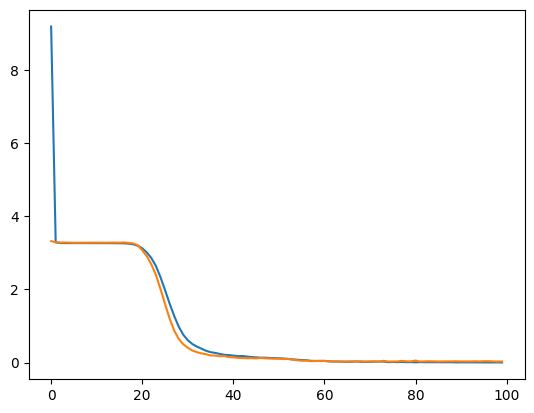

In [24]:
plt.plot(total_train_loss)
plt.plot(total_test_loss)

In [25]:
test_img = test_dataset[0]['images']
test_lbl = ''.join(lbl_enc.inverse_transform(test_dataset[0]['targets']-1))

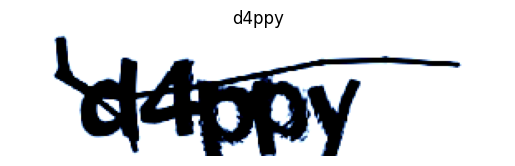

In [26]:
plt.imshow(test_img.permute(1, 2, 0))
plt.title(test_lbl)
plt.axis('off');

In [27]:
test_img[np.newaxis, :, :, :].shape

torch.Size([1, 3, 75, 300])

In [28]:
test_pred, _ = model(test_img[np.newaxis, :, :, :].to(DEVICE))

In [29]:
test_pred

tensor([[[13.3590, -4.0628, -4.0358,  ..., -2.9773, -3.9625, -4.6476]],

        [[14.0312, -3.9692, -3.8930,  ..., -3.0230, -4.4176, -4.8241]],

        [[14.0434, -3.9881, -3.8875,  ..., -3.0247, -4.4123, -4.8221]],

        ...,

        [[14.0494, -4.0578, -3.8552,  ..., -3.0772, -4.3848, -4.8695]],

        [[14.0418, -4.0411, -3.8007,  ..., -3.1372, -4.3835, -4.9387]],

        [[13.6341, -3.6056, -3.1030,  ..., -3.1598, -4.4306, -4.9796]]],
       device='cuda:0', grad_fn=<PermuteBackward0>)

In [30]:
decode_preds(test_pred, lbl_enc)

['d4py']

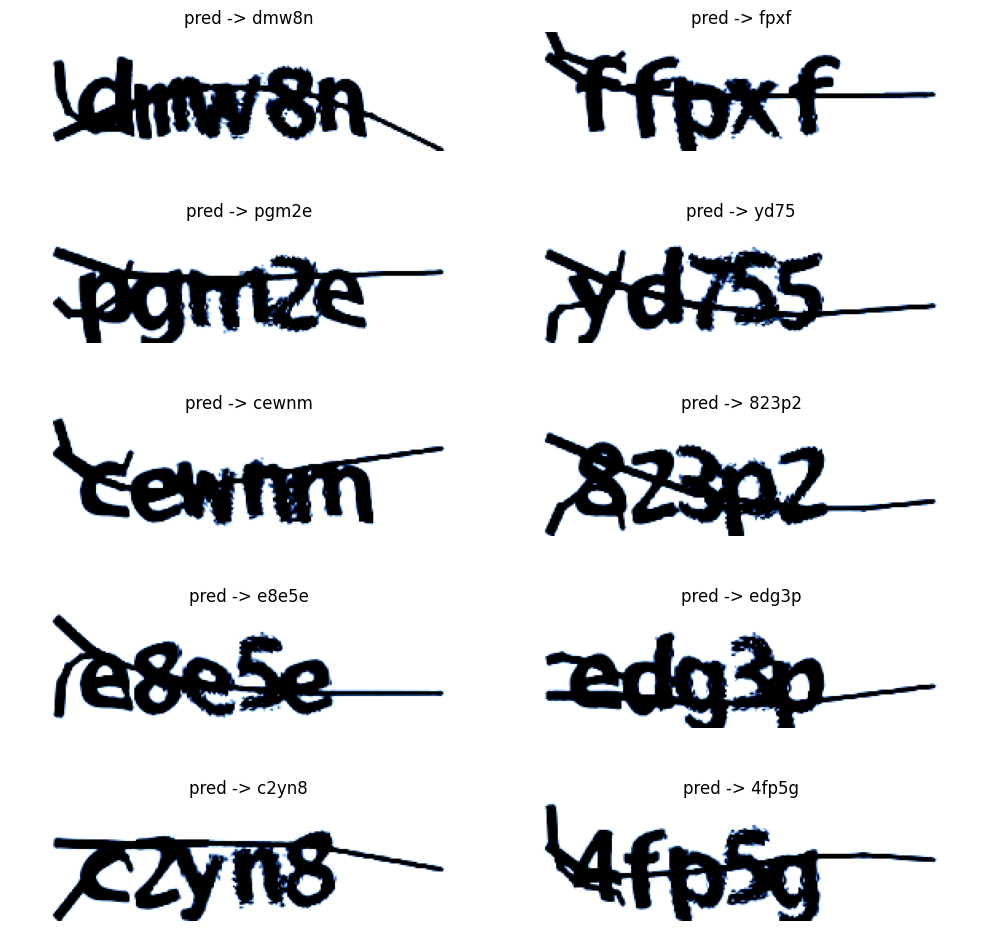

In [31]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    random_idx = random.randint(0, len(test_dataset)-1)
    img = test_dataset[random_idx]['images']
    img = img[np.newaxis, :, :, :]
#     img = img[0].permute(1, 2, 0).to(DEVICE)
    preds, _ = model(img.to(DEVICE))
    label = decode_preds(preds, lbl_enc)
    
    ax.imshow(img[0].permute(1, 2, 0))
    ax.set_title(f"pred -> {''.join(label)}")
    ax.axis('off')

plt.tight_layout()
plt.show()